# Upvote Predictor

This jupyter notebook will predict the amount of upvotes that a comment on Reddit will have. Adapted from: https://towardsdatascience.com/predicting-reddit-comment-karma-a8f570b544fc

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
load_dotenv()

CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET=os.getenv('CLIENT_SECRET')
APP_NAME=os.getenv('APP_NAME')
REDDIT_USERNAME=os.getenv('REDDIT_USERNAME')
REDDIT_PASSWORD=os.getenv('REDDIT_PASSWORD')

import praw
import pandas as pd
import datetime as dt

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=APP_NAME, username=REDDIT_USERNAME, password=REDDIT_PASSWORD)

print(reddit.user.me())

%matplotlib inline

mattcat26


In [29]:
def model_diagnostics(model, pr=True):
    """
    Returns and prints the R-squared, RMSE and the MAE
    for a trained model
    """
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    if pr:
        print(f"R-Sq: {r2:.4}")
        print(f"RMSE: {np.sqrt(mse)}")
        print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]


def plot_residuals(y_test, y_predicted):
    """"
    Plots the distribution for actual and
    predicted values of the target variable.
    Also plots the distribution for the residuals
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)
    sns.distplot(y_test, ax=ax0, kde = False)
    ax0.set(xlabel='Test scores')
    sns.distplot(y_predicted, ax=ax1, kde = False)
    ax1.set(xlabel="Predicted scores")
    plt.show()
    fig, ax2 = plt.subplots()
    sns.distplot((y_test-y_predicted), ax = ax2,kde = False)
    ax2.set(xlabel="Residuals")
    plt.show()
    
    
def y_test_vs_y_predicted(y_test,y_predicted):
    """
    Produces a scatter plot for the actual and
    predicted values of the target variable
    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylim([-75, 1400])
    ax.set_ylabel("Predicted Scores")
    plt.show()
    
    
def get_feature_importance(model):
    """
    For fitted tree based models, get_feature_importance
    can be used to get the feature importance as a tidy output
    """
    X_non_text = pd.get_dummies(comment_data[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)
    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
    print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

In [30]:
subreddit = reddit.subreddit('neutralnews')

In [31]:
for x in subreddit.top(limit=1):
    submission = x

features = ['edited', 'subreddit', 'distinguished', 'gilded', 'controversiality', 'score', 'depth', 'is_submitter', 'created_utc', 'author_flair_css_class', 'likes']

comments_dict = {}

for feature in features:
    comments_dict[feature] = []

# import pprint
# for comment in submission.comments.list():
#     pprint.pprint(vars(comment))
#     break

submission.comments.replace_more(limit=None)

for comment in submission.comments.list():
    comments_dict['edited'].append(comment.edited)
    comments_dict['subreddit'].append(comment.subreddit)
    comments_dict['distinguished'].append(comment.distinguished)
    comments_dict['gilded'].append(comment.gilded)
    comments_dict['controversiality'].append(comment.controversiality)
    comments_dict['score'].append(comment.score)
    comments_dict['depth'].append(comment.depth)
    
    comments_dict['is_submitter'].append(comment.is_submitter)
    comments_dict['created_utc'].append(comment.created_utc)
    comments_dict['author_flair_css_class'].append(comment.author_flair_css_class)
#     comments_dict['author_premium'].append(comment.author_premium)
    comments_dict['likes'].append(comment.likes)
#     comments_dict['author_patreon_flair'].append(comment.author_patreon_flair)
    
#     comments_dict['over_18'].append(comment.over_18)
#     comments_dict['is_quoted'].append(comment.is_quoted)
#     comments_dict['is_selftext'].append(comment.is_selftext)
#     comments_dict['time_since_link'].append(comment.time_since_link)
#     comments_dict['is_flair'].append(comment.is_flair)
#     comments_dict['is_flair_css'].append(comment.is_flair_css)
#     comments_dict['hour_of_comment'].append(comment.hour_of_comment)
#     comments_dict['weekday'].append(comment.weekday)
#     comments_dict['no_of_linked_sr'].append(comment.no_of_linked_sr)
#     comments_dict['no_of_linked_urls'].append(comment.no_of_linked_urls)
#     comments_dict['parent_score'].append(comment.parent_score)
#     comments_dict['comment_tree_root_score'].append(comment.comment_tree_root_score)
#     comments_dict['time_since_comment_tree_root'].append(comment.time_since_comment_tree_root)
#     comments_dict['subjectivity'].append(comment.subjectivity)
#     comments_dict['senti_neg'].append(comment.senti_neg)
#     comments_dict['senti_pos'].append(comment.senti_pos)
#     comments_dict['senti_neu'].append(comment.senti_neu)
#     comments_dict['senti_comp'].append(comment.senti_comp)
#     comments_dict['no_quoted'].append(comment.no_quoted)
#     comments_dict['time_since_parent'].append(comment.time_since_parent)
#     comments_dict['word_counts'].append(comment.word_counts)
#     comments_dict['no_of_past_comments'].append(comment.no_of_past_comments)
#     comments_dict['parent_cosine'].append(comment.parent_cosine)
#     comments_dict['parent_euc'].append(comment.parent_euc)
#     comments_dict['title_cosine'].append(comment.title_cosine)
#     comments_dict['title_euc'].append(comment.title_euc)
#     comments_dict['link_score'].append(comment.link_score)
    
    
# comment_data = pd.DataFrame(comments_dict)
# print(comment_data.head())

print('\n\n')
print('DONE')







DONE


In [32]:
comment_data = pd.DataFrame(comments_dict)
comment_data.head()

,edited,subreddit,distinguished,gilded,controversiality,score,depth,is_submitter,created_utc,author_flair_css_class,likes
0,False,neutralnews,moderator,0,0,1,0,False,1.487510e+09,None,None
1,False,neutralnews,moderator,0,0,176,0,False,1.487529e+09,None,None
2,1.48756e+09,neutralnews,None,0,0,455,0,False,1.487517e+09,None,None
3,False,neutralnews,None,0,0,309,0,False,1.487526e+09,None,None
4,False,neutralnews,None,0,0,46,0,False,1.487541e+09,None,None


In [33]:
comment_data['edited'][comment_data['edited'] != False] = 1
comment_data['edited'][comment_data['edited'] == False] = 0
comment_data = comment_data.drop(columns=['created_utc', 'subreddit'])

comment_data['edited'] = comment_data['edited'].astype('bool')
comment_data

,edited,distinguished,gilded,controversiality,score,depth,is_submitter,author_flair_css_class,likes
0,False,moderator,0,0,1,0,False,None,None
1,False,moderator,0,0,176,0,False,None,None
2,True,None,0,0,455,0,False,None,None
3,False,None,0,0,309,0,False,None,None
4,False,None,0,0,46,0,False,None,None
...,...,...,...,...,...,...,...,...,...
331,False,None,0,0,1,7,False,None,None
332,False,None,0,0,2,8,False,None,None
333,False,None,0,0,1,8,False,None,None
334,False,None,0,0,1,9,False,None,None


In [34]:
comment_data.dtypes

edited                      bool
distinguished             object
gilded                     int64
controversiality           int64
score                      int64
depth                      int64
is_submitter                bool
author_flair_css_class    object
likes                     object
dtype: object

In [35]:
bool_cols = ['edited', 'is_submitter']
cat_cols = ['distinguished', 'author_flair_css_class']
numeric_cols = ['gilded', 'controversiality', 'depth']

In [36]:
lb = LabelBinarizer()
cat = [lb.fit_transform(comment_data[col].astype('str')) for col in cat_cols]
bol = [comment_data[col].astype('int') for col in bool_cols]
t = comment_data.loc[:, numeric_cols].values
final = [t] + bol + cat
y = comment_data.score.values
x = np.column_stack(tuple(final))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=10)

In [38]:
model_performance_dict = dict()

In [39]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -0.002033
RMSE: 24.244740287518624
MAE: 13.704145936981757


In [40]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -0.002033
RMSE: 24.244740287518624
MAE: 13.704145936981757


In [41]:
lasso = LassoCV(cv=30).fit(X_train, y_train)
model_performance_dict["Lasso Regression"] = model_diagnostics(lasso)

R-Sq: -0.03819
RMSE: 24.678326182469874
MAE: 14.546110284354818


In [42]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
model_performance_dict["Ridge Regression"] = model_diagnostics(ridge)

R-Sq: 0.02074
RMSE: 23.96762820513215
MAE: 13.845002514600761


In [43]:
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)
model_performance_dict["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq: 0.02373
RMSE: 23.93102461956071
MAE: 13.80341500965302


In [44]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
model_performance_dict["KNN Regression"] = model_diagnostics(knr)

R-Sq: -0.683
RMSE: 31.421012077907356
MAE: 16.696296296296296


In [45]:
dt = DecisionTreeRegressor(min_samples_split=45, min_samples_leaf=45, random_state = 10)
dt.fit(X_train, y_train)
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: 0.0864
RMSE: 23.15021272928557
MAE: 12.354689946513824


In [46]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)
model_performance_dict["Random Forest"] = model_diagnostics(rf)

R-Sq: -0.01875
RMSE: 24.446194337804492
MAE: 12.886304663587573


In [47]:
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=5)
gbr.fit(X_train, y_train)
model_performance_dict["Gradient Boosting Regression"] = model_diagnostics(gbr)

R-Sq: -0.3176
RMSE: 27.80201574312024
MAE: 13.768865764915487


In [48]:
def model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'RMSE'):

    Rsq_list = []
    RMSE_list = []
    MAE_list = []
    for key in model_performance_dict.keys():
        Rsq_list.append(model_performance_dict[key][0])
        RMSE_list.append(model_performance_dict[key][1])
        MAE_list.append(model_performance_dict[key][2])

    props = pd.DataFrame([])

    props["R-squared"] = Rsq_list
    props["RMSE"] = RMSE_list
    props["MAE"] = MAE_list
    props.index = model_performance_dict.keys()
    props = props.sort_values(by = sort_by)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(props.index, props[metric], color="blue")
    plt.title(metric)
    plt.xlabel('Model')
    plt.xticks(rotation = 45)
    plt.ylabel(metric)

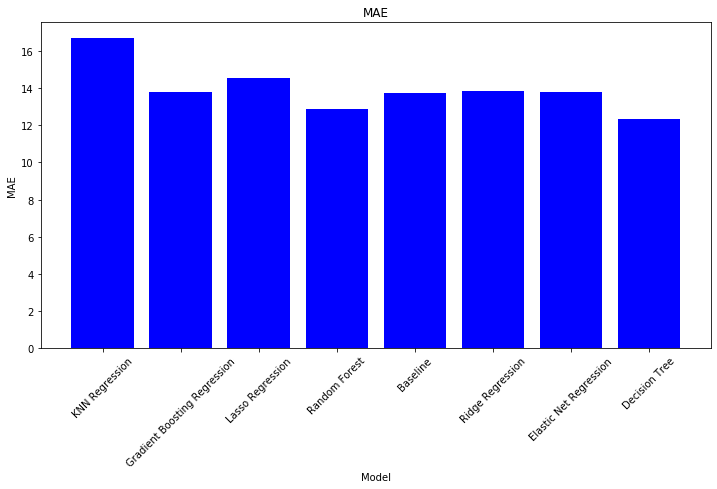

In [49]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'MAE')

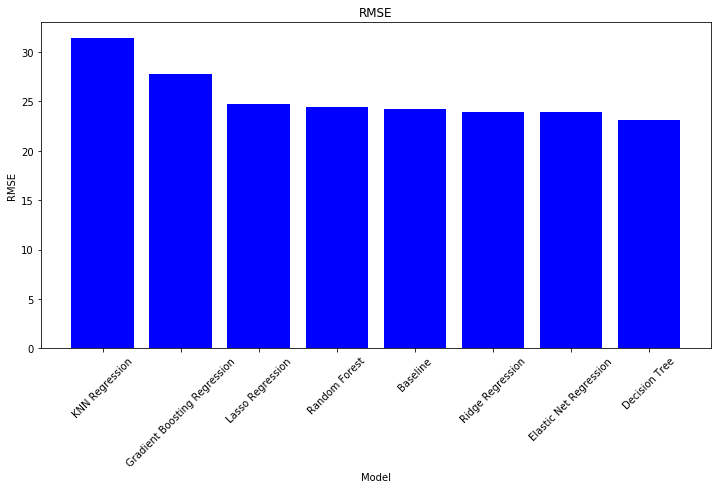

In [50]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'RMSE')

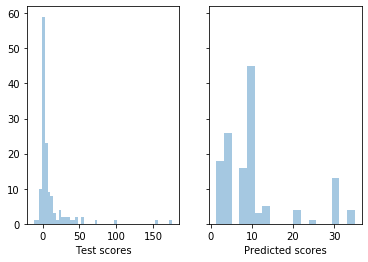

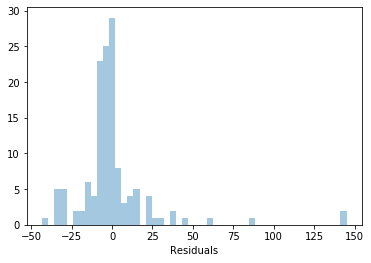

In [51]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)